# 20/05/13 - Estudos de redes com até duas camadas e de 4 a 32 neurônios e peso na perda da condição inicial e dados



## Resumo

- Função de perda: RMSE
- Parânmetros do modelo: k--0.0001__phi--0.2__ksi--0.0__cb--0.15__Cn_max--0.55__lambd_nb--1.8__mi_n--0.2__lambd_bn--0.1__y_n--0.1__t_lower--0.0__t_upper--10.0
- Funções de  ativação: 
    - LeakyReLU
    - Sigmoid
    - Elu 
    - Tanh
    - ReLU
    - SiLU

- Tamanhos de batelada e épocas:
    - (10000, 500)
    - (5000, 1000)

- Arquivo de checkpoint: 1716221142

- Peso da perda de cond. inicial: 10

- Peso da perda de dados: 10

In [1]:
import glob
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt

In [11]:
result_list = glob.glob("edo_pinn_sim/*")

print("numero de arquiteturas testadas: {}".format(len(result_list)))

numero de arquiteturas testadas: 44


In [12]:
results_dict = {}

error_list = []

speed_list = []
tmp_list = []

for file in result_list:
    i = len(error_list)
    if file.split(".")[-1] == "pkl":
        with open(file, "rb") as f:
            results_dict[i] = pk.load(f)

        results_dict[i]["arch_name"] = file.split("/")[-1].split(".")[0]

        tmp_list.append(results_dict[i]["max_ae"])
        error_list.append(results_dict[i]["rmse"])
        speed_list.append(
            results_dict[i]["mean_speed_up"] - results_dict[i]["std_speed_up"]
        )

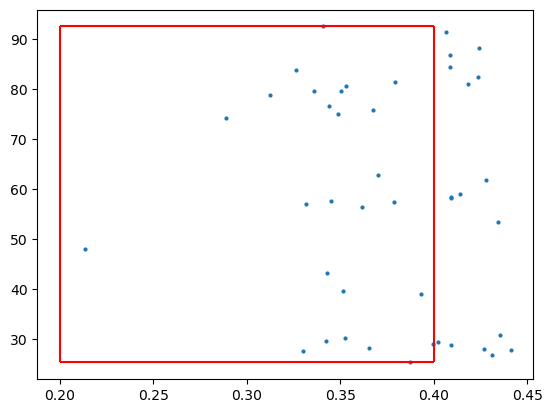

In [15]:
x_lim = (0.2, 0.4)
plt.scatter(error_list, speed_list, s=4)
plt.hlines(max(speed_list), x_lim[0], x_lim[1], color="r")
plt.hlines(min(speed_list), x_lim[0], x_lim[1], color="r")
plt.vlines(x_lim[1], min(speed_list), max(speed_list), color="r")
plt.vlines(x_lim[0], min(speed_list), max(speed_list), color="r")
plt.show()

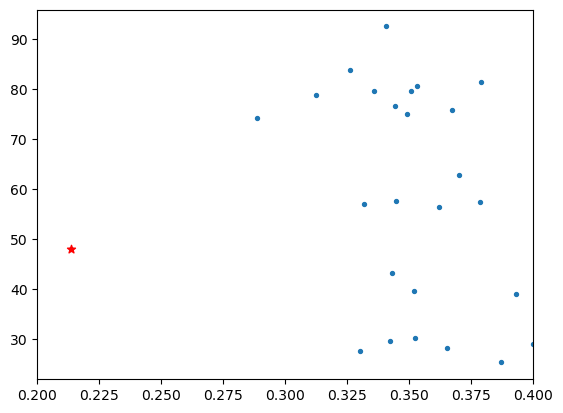

Arquitetura escolhida: epochs_700__batch_100000__arch_ReLU--8__


In [16]:
choice = np.intersect1d(
    np.argwhere(np.array(speed_list) <50), np.argwhere(np.array(error_list) < 0.25)
)[0]

plt.scatter(error_list, speed_list, s=8)
plt.scatter(error_list[choice], speed_list[choice], c="r", marker="*")
plt.xlim(x_lim[0], x_lim[1])
plt.ylim()
plt.show()

arch_str = results_dict[choice]["arch_name"]

print("Arquitetura escolhida: " + arch_str)

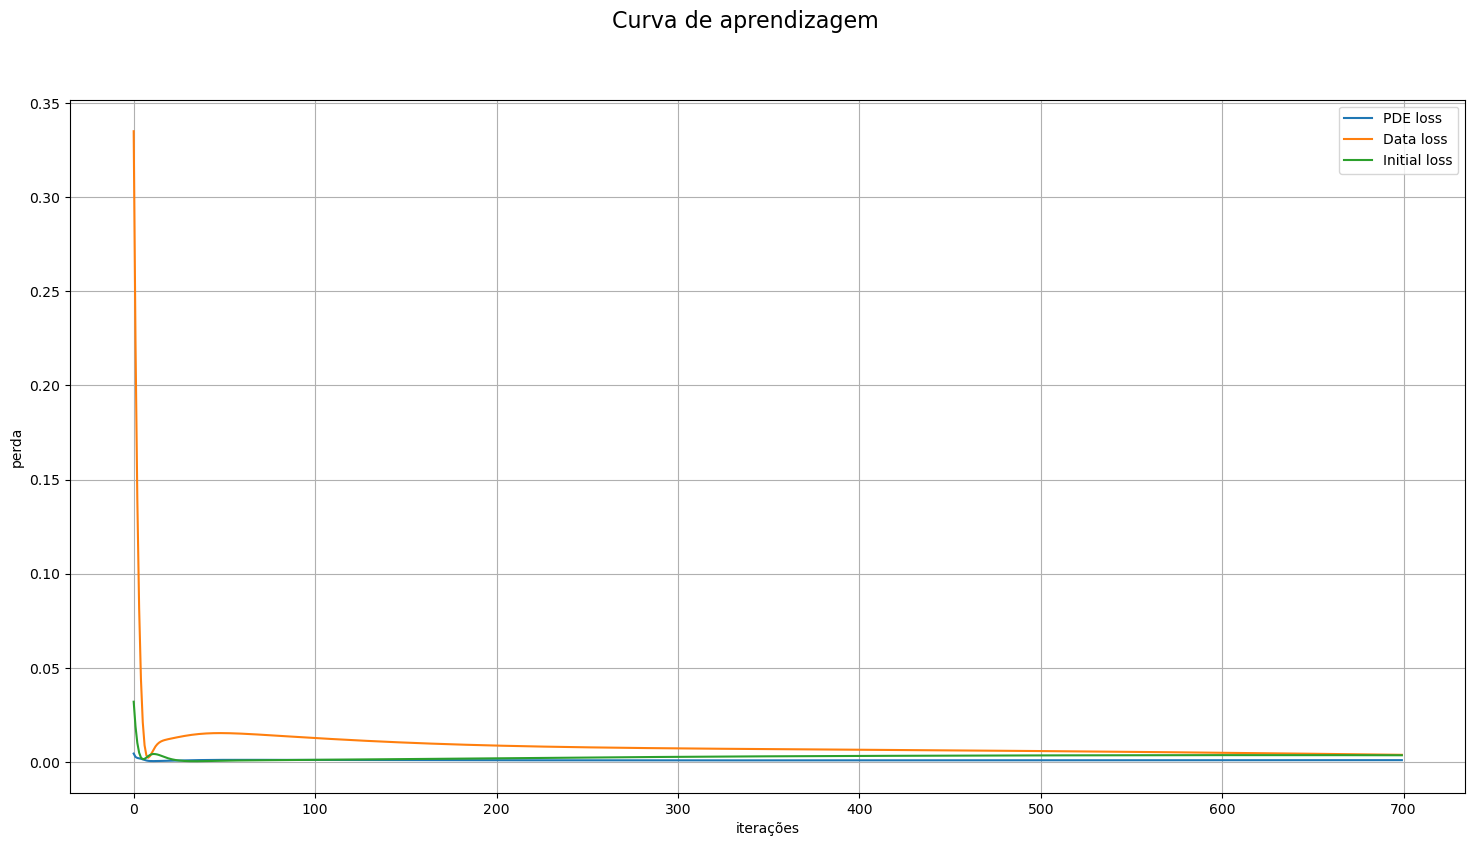

In [17]:
with open("learning_curves/C_pde_loss_it__" + arch_str + ".pkl", "rb") as f:
    C_pde_loss_it = pk.load(f)

with open("learning_curves/C_data_loss_it__" + arch_str + ".pkl", "rb") as f:
    C_data_loss_it = pk.load(f)

with open("learning_curves/C_initial_loss_it__" + arch_str + ".pkl", "rb") as f:
    C_initial_loss_it = pk.load(f)

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")
ax.plot(
    range(len(C_pde_loss_it)),
    C_pde_loss_it,
    label="PDE loss",
)
ax.plot(
    range(len(C_data_loss_it)),
    C_data_loss_it,
    label="Data loss",
)
ax.plot(
    range(len(C_initial_loss_it)),
    C_initial_loss_it,
    label="Initial loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

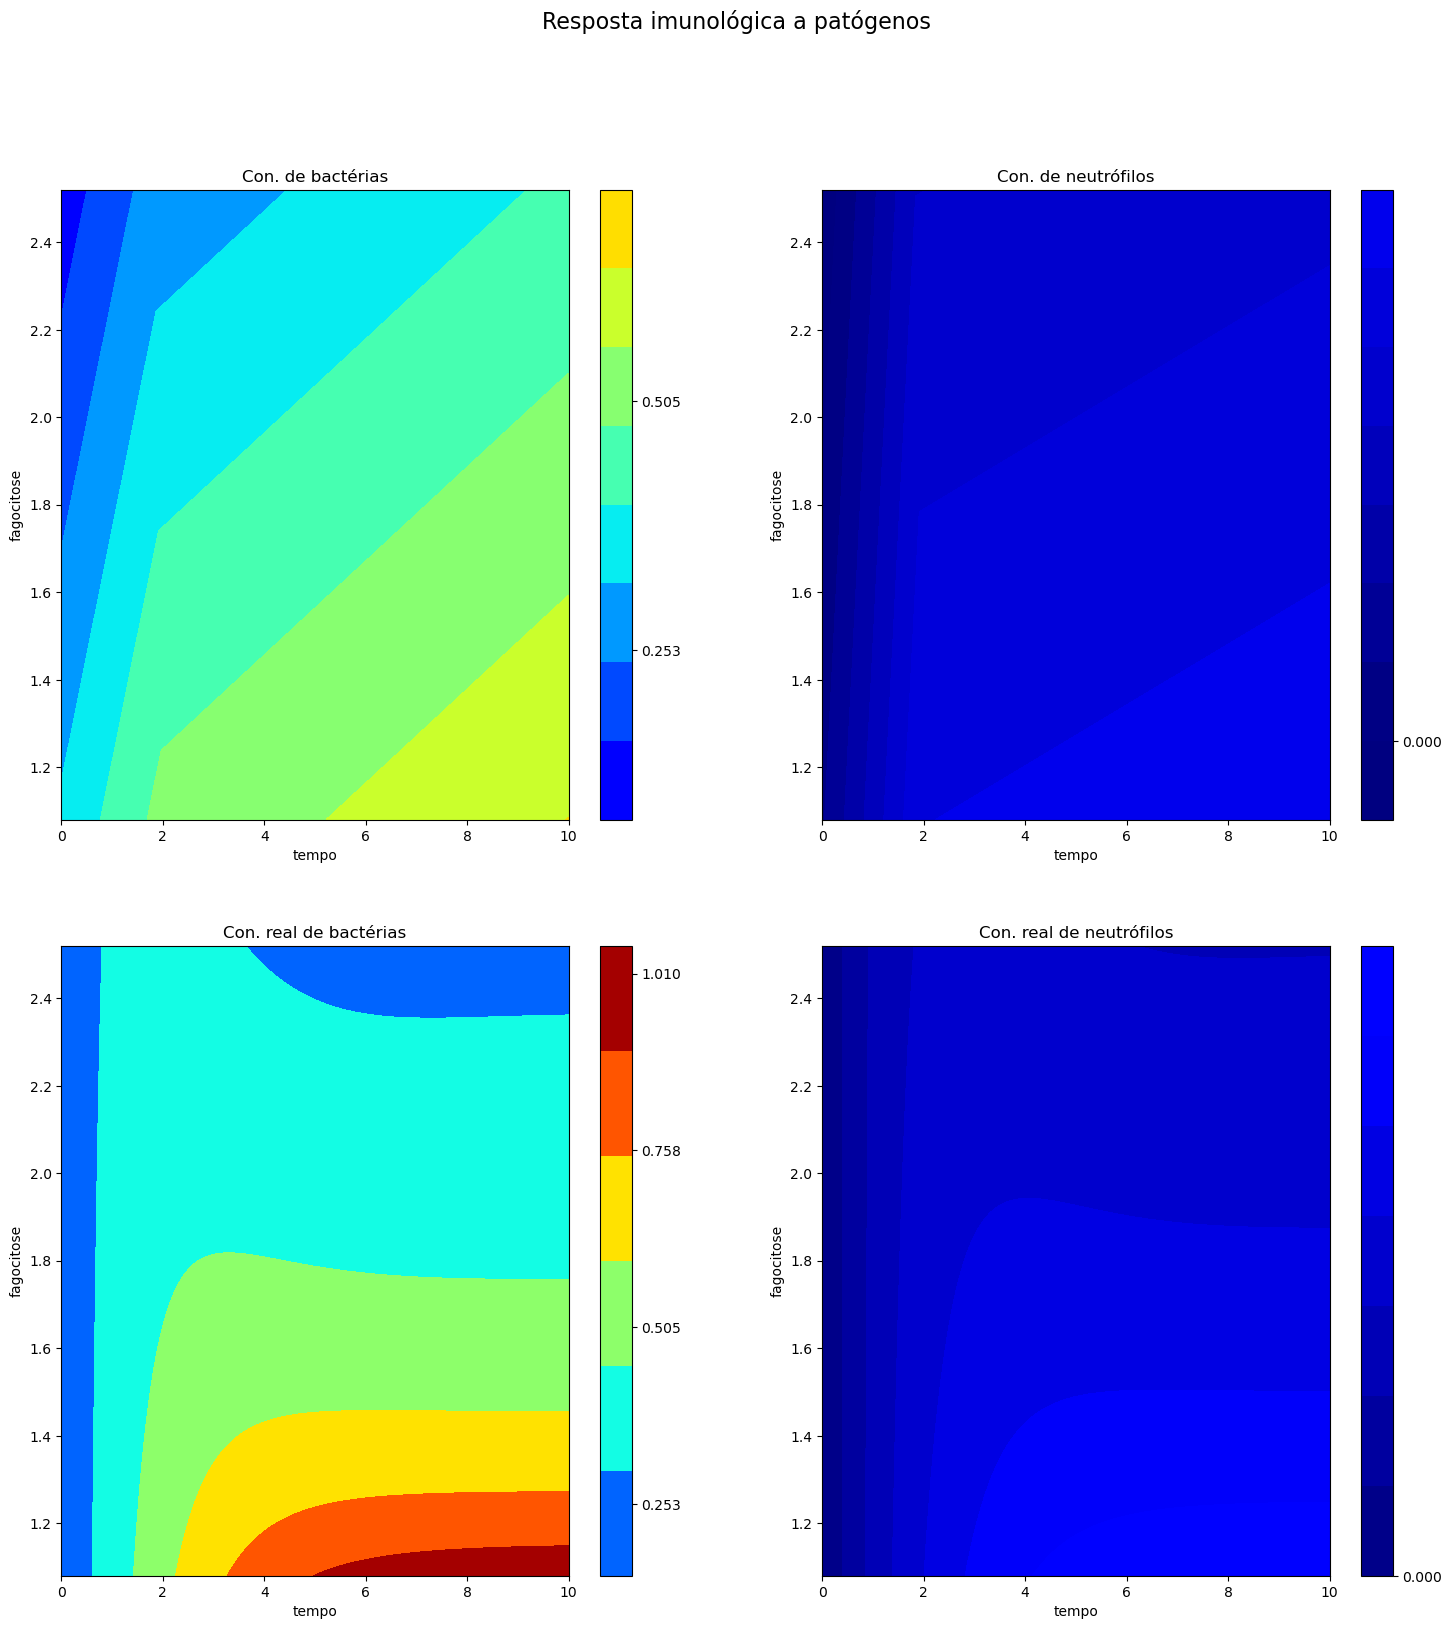

Speed Up: 65.35466037638305 +/-17.42704821401545


In [18]:
results_dict[choice]

Cl_pinn_lin = results_dict[choice]["Cl_pinn"].numpy()
Cp_pinn_lin = results_dict[choice]["Cp_pinn"].numpy()

size_t = int(len(Cl_pinn_lin)**0.5)

struct_name = "k--0.01__phi--0.2__ksi--0.0__cb--0.15__Cn_max--0.55__lambd_nb--1.8__mi_n--0.2__lambd_bn--0.1__y_n--0.1__t_lower--0.0__t_upper--10.0"


with open("edo_fdm_sim/Cp__" + struct_name + ".pkl", "rb") as f:
    Cp = pk.load(f)

with open("edo_fdm_sim/Cl__" + struct_name + ".pkl", "rb") as f:
    Cl = pk.load(f)

Cl_pinn_np = Cl_pinn_lin.reshape(size_t , size_t )
Cp_pinn_np = Cp_pinn_lin.reshape(size_t , size_t )

fig = plt.figure(figsize=[18, 18])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)

vmin = 0
vmax = np.max(
    [
        np.max(Cl_pinn_lin),
        np.max(Cp_pinn_lin),
        np.max(Cp),
        np.max(Cl),
    ]
)

lmb_var = 0.4

lmb_list = np.linspace(
    1.8 * (1 - lmb_var), 1.8 * (1 + lmb_var), num=size_t, endpoint=True
)

t_np = np.linspace(0, 10, num=size_t, endpoint=True)

tt, ll = np.meshgrid(t_np, lmb_list)

# Plotango 3D
ax = fig.add_subplot(2, 2, 1)

contour = ax.contourf(
    tt,
    ll,
    Cp_pinn_np,
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. de bactérias")
ax.set_xlabel("tempo")
ax.set_ylabel("fagocitose")
colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotando 2D

ax = fig.add_subplot(2, 2, 2)

contour = ax.contourf(
    tt,
    ll,
    Cl_pinn_np,
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. de neutrófilos")
ax.set_xlabel("tempo")
ax.set_ylabel("fagocitose")

colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotango 3D
ax = fig.add_subplot(2, 2, 3)

contour = ax.contourf(
    tt,
    ll,
    Cp.reshape(size_t, size_t),
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. real de bactérias")
ax.set_xlabel("tempo")
ax.set_ylabel("fagocitose")
colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotando 2D

ax = fig.add_subplot(2, 2, 4)

contour = ax.contourf(
    tt,
    ll,
    Cl.reshape(size_t, size_t),
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. real de neutrófilos")
ax.set_xlabel("tempo")
ax.set_ylabel("fagocitose")

colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

plt.show()

print(
    "Speed Up: {} +/-{}".format(
        results_dict[choice]["mean_speed_up"], results_dict[choice]["std_speed_up"]
    )
)

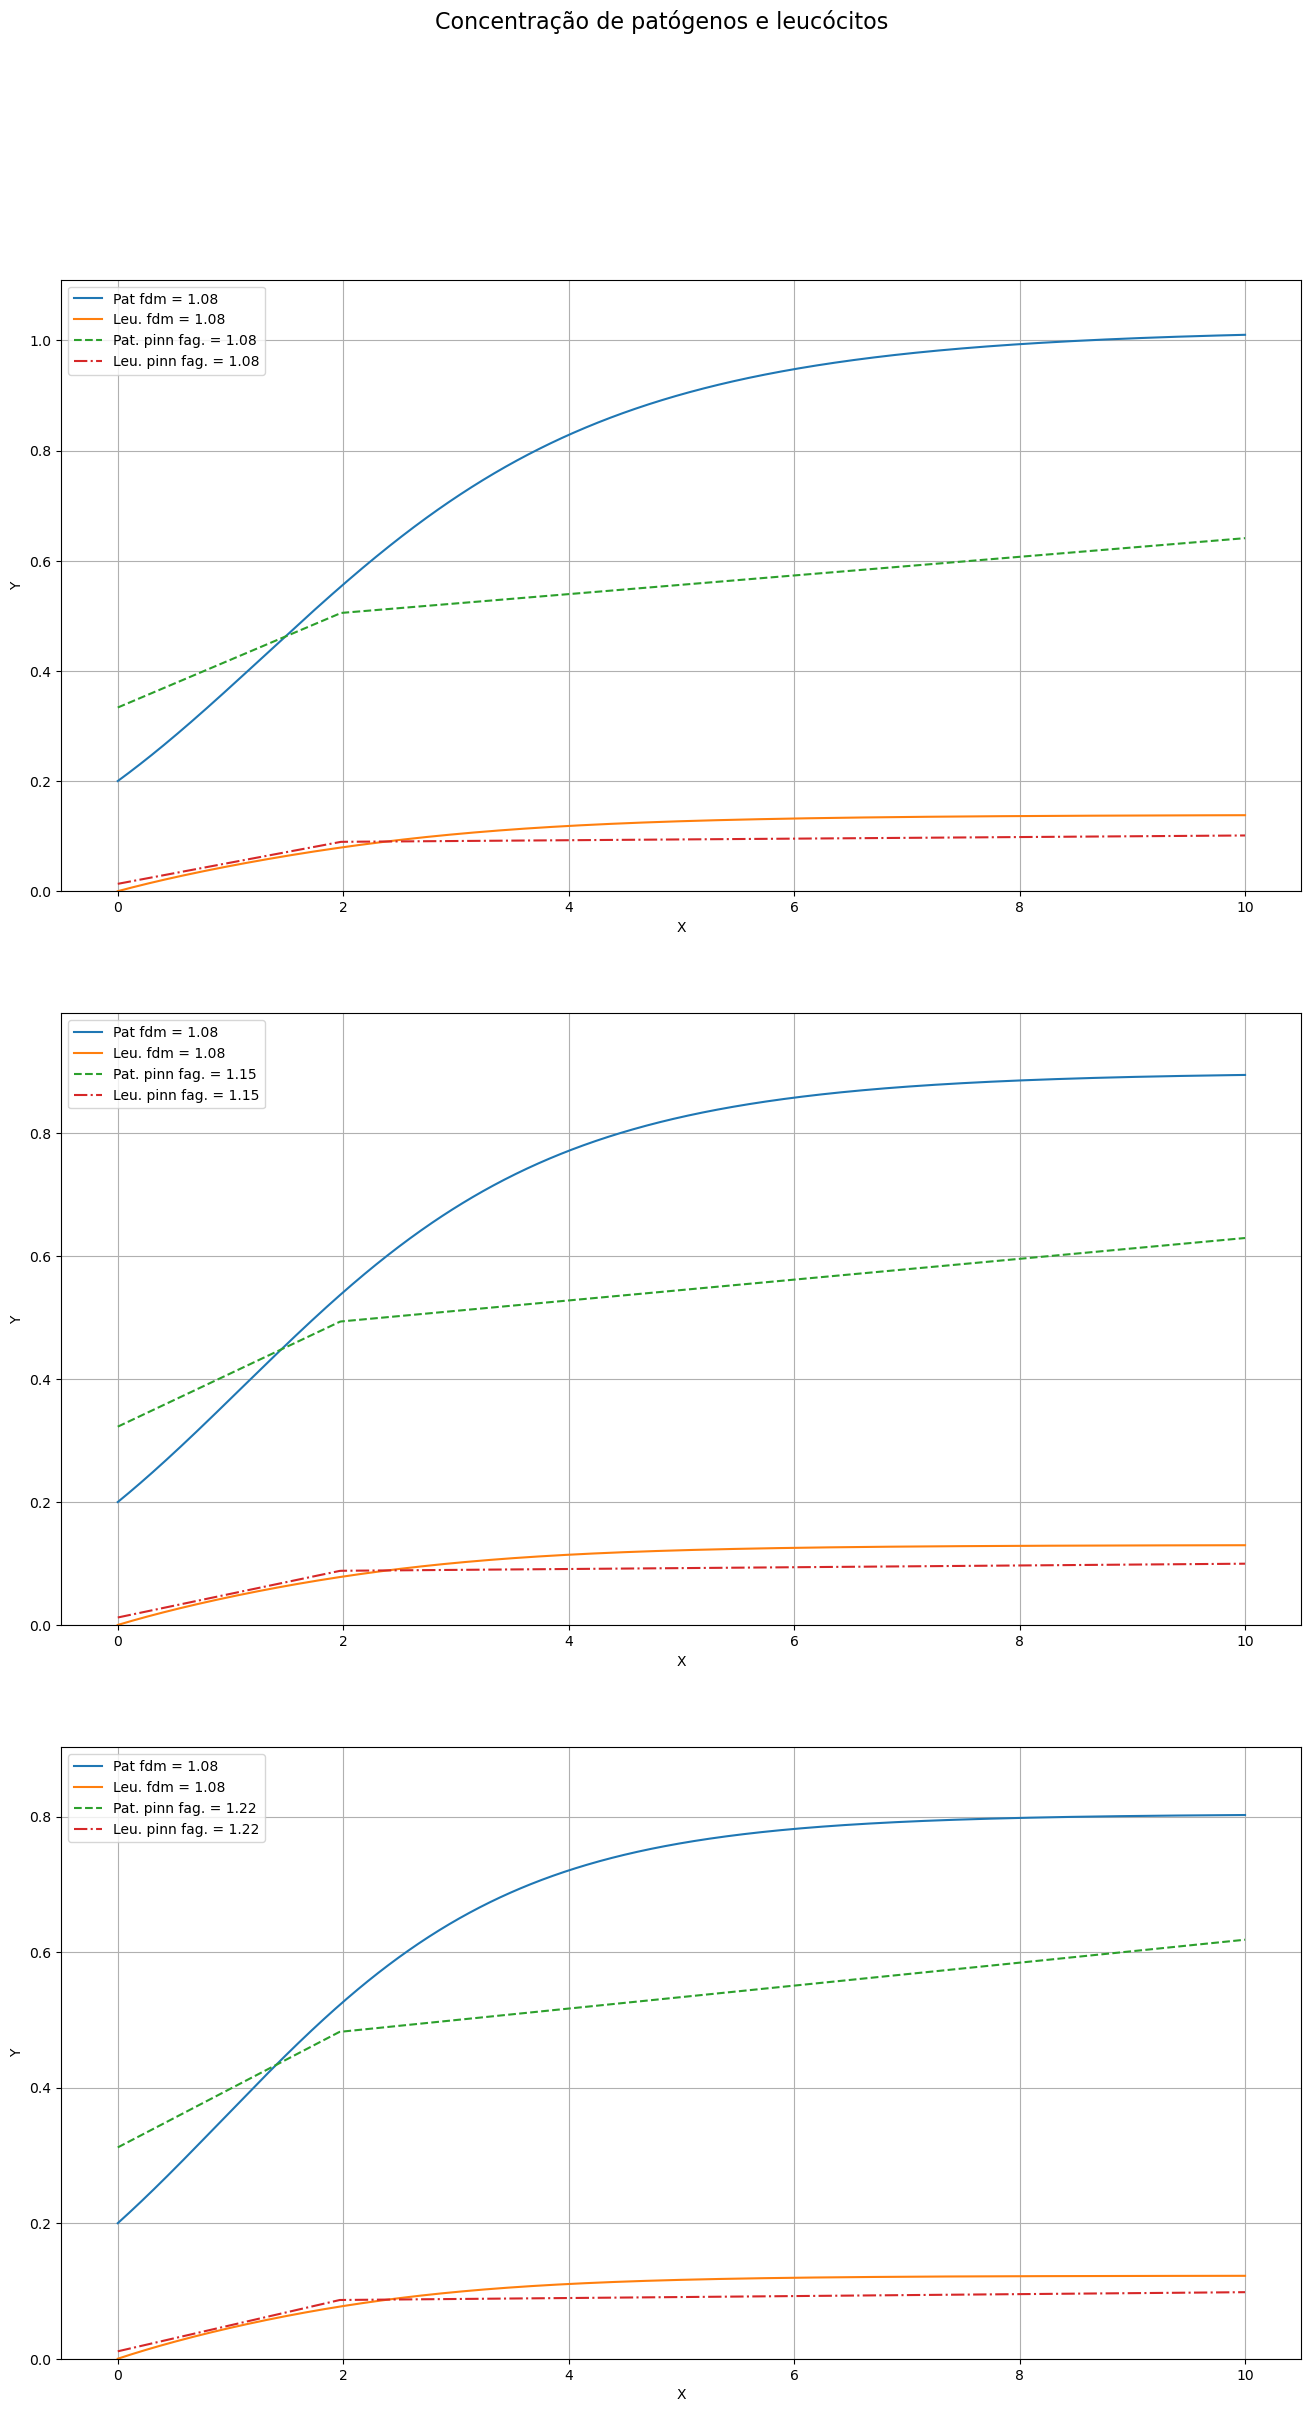

In [19]:

fig = plt.figure(figsize=[16, 27])

fig.suptitle("Concentração de patógenos e leucócitos", fontsize=16)


vmin = 0

cp_real_1 = Cp[0, :]
cl_real_1 = Cl[0, :]
cp_pinn_1 = Cp_pinn_np[0, :]
cl_pinn_1 = Cl_pinn_np[0, :]
fag_1 = lmb_list[0]

cp_real_2 = Cp[50, :]
cl_real_2 = Cl[50, :]
cp_pinn_2 = Cp_pinn_np[50, :]
cl_pinn_2 = Cl_pinn_np[50, :]
fag_2 = lmb_list[50]

cp_real_3 = Cp[100, :]
cl_real_3 = Cl[100, :]
cp_pinn_3 = Cp_pinn_np[100, :]
cl_pinn_3 = Cl_pinn_np[100, :]
fag_3 = lmb_list[100]

# Plotango 3D
ax = fig.add_subplot(3, 1, 1)

ax.plot(t_np, cp_real_1, label="Pat fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cl_real_1, label="Leu. fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cp_pinn_1, "--", label="Pat. pinn fag. = {:.2f}".format(fag_1))
ax.plot(t_np, cl_pinn_1, "-.", label="Leu. pinn fag. = {:.2f}".format(fag_1))
ax.set_xlabel("X")
ax.set_ylabel("Y")

vmax = np.max(
    [
        np.max(cp_real_1),
        np.max(cl_real_1),
        np.max(cp_pinn_1),
        np.max(cl_pinn_1),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

ax = fig.add_subplot(3, 1, 2)

ax.plot(t_np, cp_real_2, label="Pat fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cl_real_2, label="Leu. fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cp_pinn_2, "--", label="Pat. pinn fag. = {:.2f}".format(fag_2))
ax.plot(t_np, cl_pinn_2, "-.", label="Leu. pinn fag. = {:.2f}".format(fag_2))
ax.set_xlabel("X")
ax.set_ylabel("Y")
vmax = np.max(
    [
        np.max(cp_real_2),
        np.max(cl_real_2),
        np.max(cp_pinn_2),
        np.max(cl_pinn_2),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

ax = fig.add_subplot(3, 1, 3)

ax.plot(t_np, cp_real_3, label="Pat fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cl_real_3, label="Leu. fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cp_pinn_3, "--", label="Pat. pinn fag. = {:.2f}".format(fag_3))
ax.plot(t_np, cl_pinn_3, "-.", label="Leu. pinn fag. = {:.2f}".format(fag_3))
ax.set_xlabel("X")
ax.set_ylabel("Y")
vmax = np.max(
    [
        np.max(cp_real_3),
        np.max(cl_real_3),
        np.max(cp_pinn_3),
        np.max(cl_pinn_3),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

plt.show()

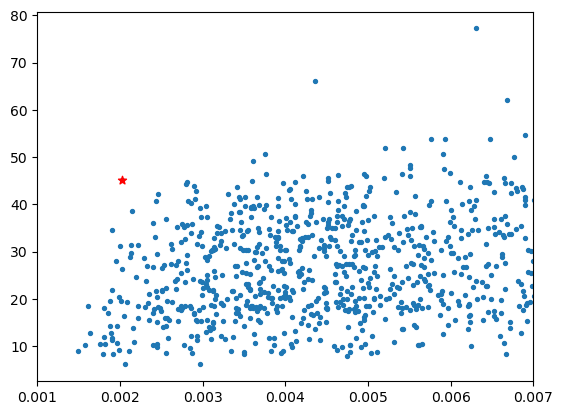

Arquitetura escolhida: epochs_500__batch_10000__arch_SiLU--8__LeakyReLU--4__


In [ ]:
choice = np.intersect1d(
    np.argwhere(np.array(speed_list) > 43), np.argwhere(np.array(error_list) < 0.0022)
)[0]

plt.scatter(error_list, speed_list, s=8)
plt.scatter(error_list[choice], speed_list[choice], c="r", marker="*")
# plt.hlines(25,0.01,0.15)
# plt.vlines(0.0108,min(speed_list),max(speed_list))
plt.xlim(0.001, 0.007)
plt.ylim()
plt.show()

arch_str = results_dict[choice]["arch_name"]

print("Arquitetura escolhida: " + arch_str)

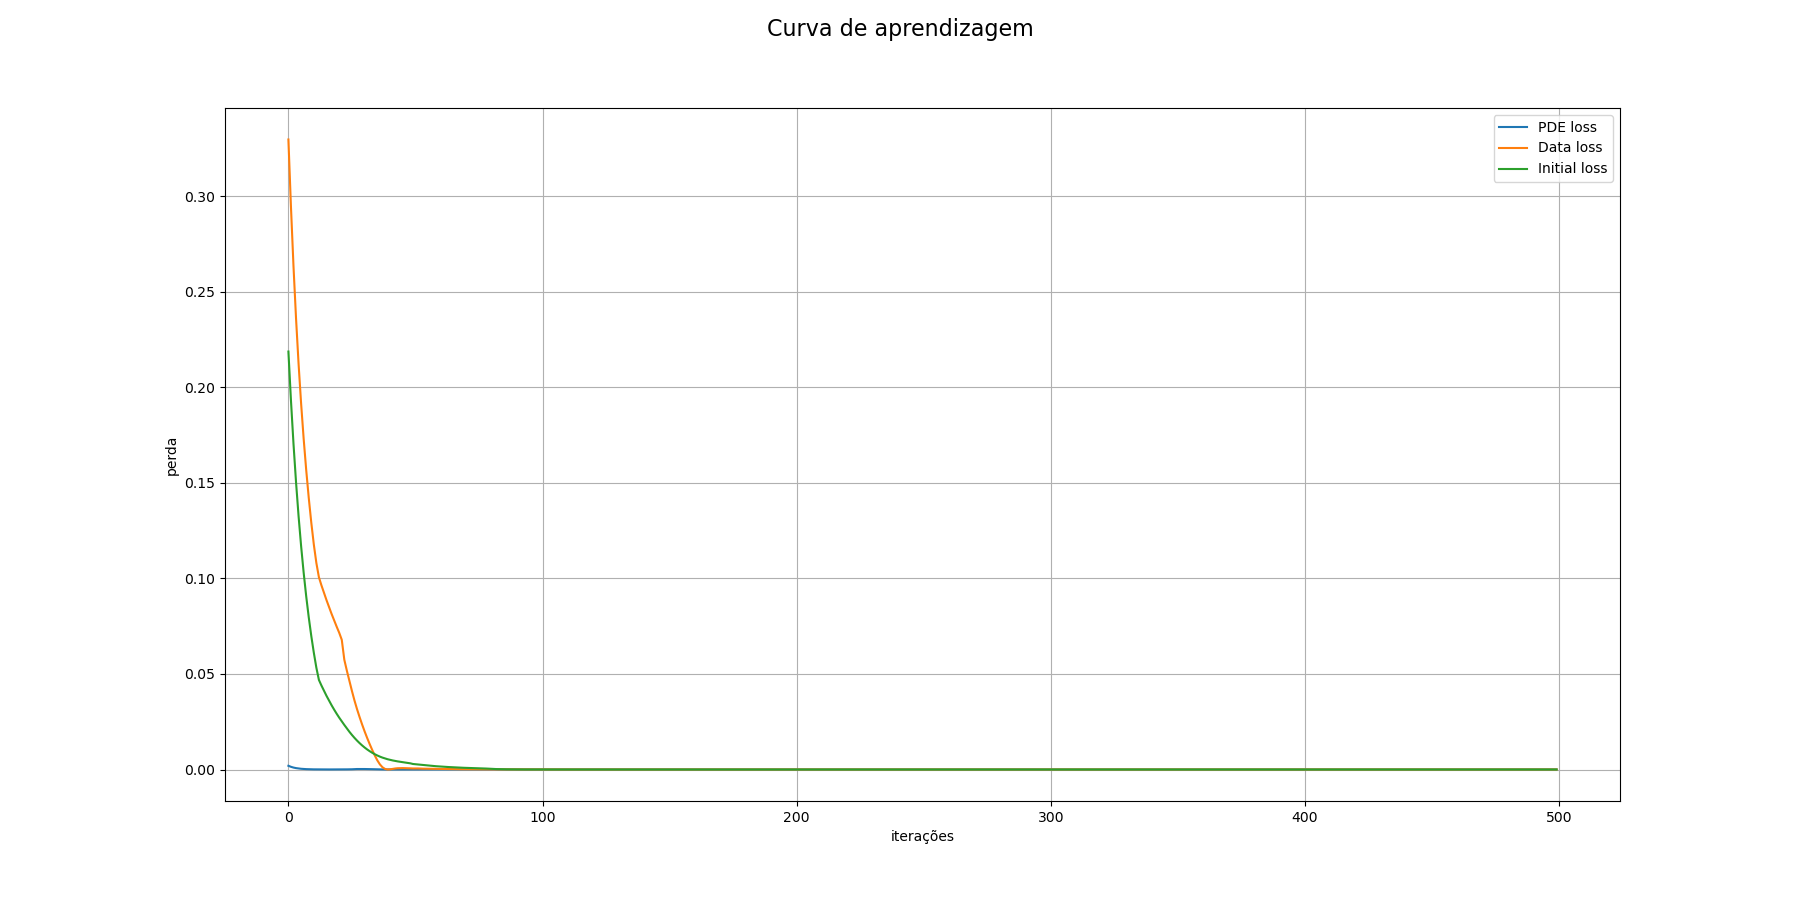

In [ ]:
from IPython.display import Image

Image("learning_curves/" + arch_str + ".png")

In [21]:
int(len(Cl_pinn_lin)**0.5)

101

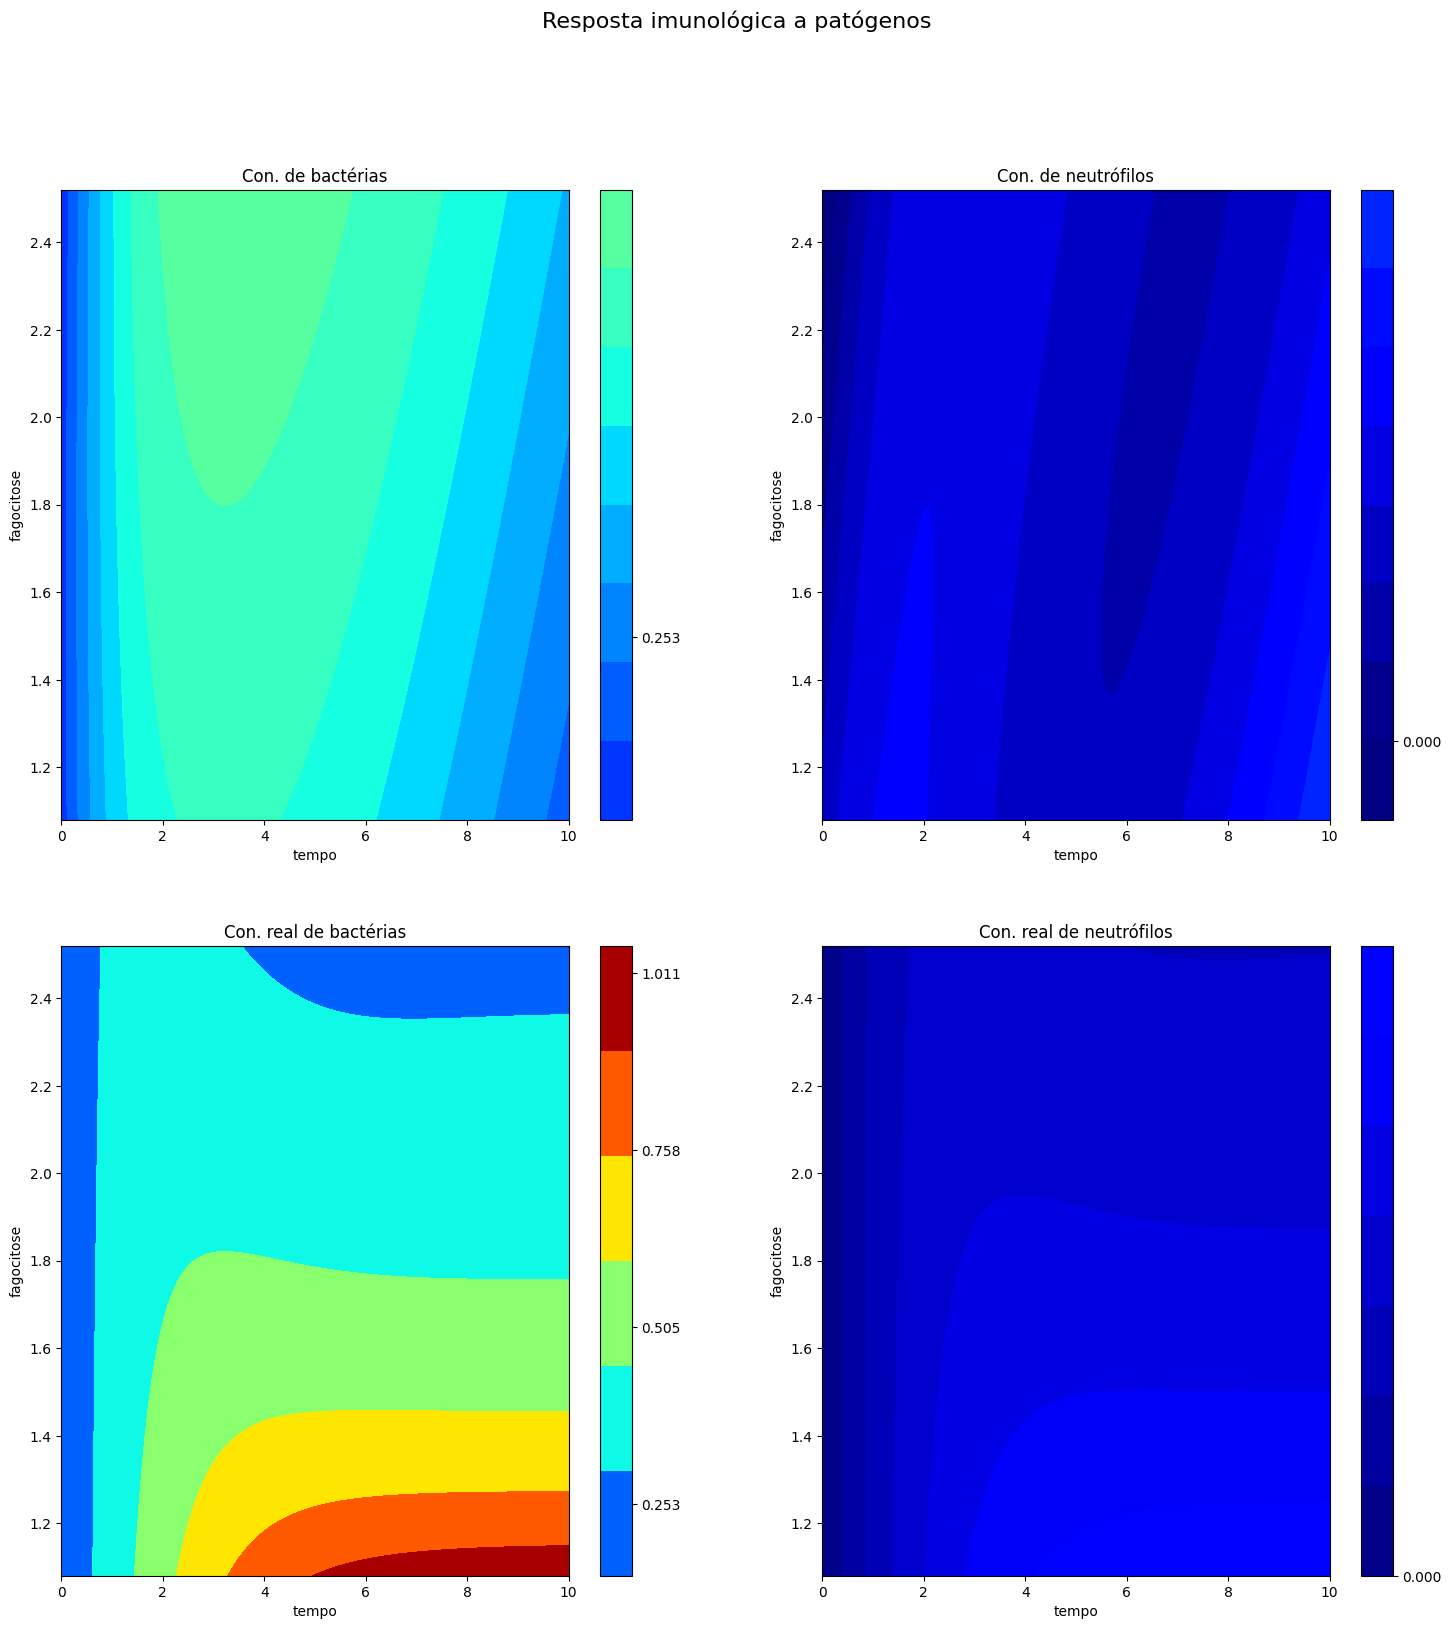

Speed Up: 21.929414622782307 +/-5.185747408258397


In [22]:
results_dict[choice]

Cl_pinn_lin = results_dict[choice]["Cl_pinn"].numpy()
Cp_pinn_lin = results_dict[choice]["Cp_pinn"].numpy()

size_t = int(len(Cl_pinn_lin)**0.5)

struct_name = "k--0.1__phi--0.2__ksi--0.0__cb--0.15__Cn_max--0.55__lambd_nb--1.8__mi_n--0.2__lambd_bn--0.1__y_n--0.1__t_lower--0.0__t_upper--10.0"


with open("edo_fdm_sim/Cp__" + struct_name + ".pkl", "rb") as f:
    Cp = pk.load(f)

with open("edo_fdm_sim/Cl__" + struct_name + ".pkl", "rb") as f:
    Cl = pk.load(f)

Cl_pinn_np = Cl_pinn_lin.reshape(size_t, size_t)
Cp_pinn_np = Cp_pinn_lin.reshape(size_t, size_t)

lmb_var = 0.4

lmb_list = np.linspace(
    1.8 * (1 - lmb_var), 1.8 * (1 + lmb_var), num=size_t, endpoint=True
)

t_np = np.linspace(0, 10, num=size_t, endpoint=True)

fig = plt.figure(figsize=[18, 18])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)

vmin = 0
vmax = np.max(
    [
        np.max(Cp_pinn_np),
        np.max(Cl_pinn_np),
        np.max(Cp),
        np.max(Cl),
    ]
)

# Plotango 3D
ax = fig.add_subplot(2, 2, 1)

contour = ax.contourf(
    tt,
    ll,
    Cp_pinn_np,
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. de bactérias")
ax.set_xlabel("tempo")
ax.set_ylabel("fagocitose")
colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotando 2D

ax = fig.add_subplot(2, 2, 2)

contour = ax.contourf(
    tt,
    ll,
    Cl_pinn_np,
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. de neutrófilos")
ax.set_xlabel("tempo")
ax.set_ylabel("fagocitose")

colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotango 3D
ax = fig.add_subplot(2, 2, 3)

contour = ax.contourf(
    tt,
    ll,
    Cp,
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. real de bactérias")
ax.set_xlabel("tempo")
ax.set_ylabel("fagocitose")
colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotando 2D

ax = fig.add_subplot(2, 2, 4)

contour = ax.contourf(
    tt,
    ll,
    Cl,
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. real de neutrófilos")
ax.set_xlabel("tempo")
ax.set_ylabel("fagocitose")

colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

plt.show()

print(
    "Speed Up: {} +/-{}".format(
        results_dict[choice]["mean_speed_up"], results_dict[choice]["std_speed_up"]
    )
)

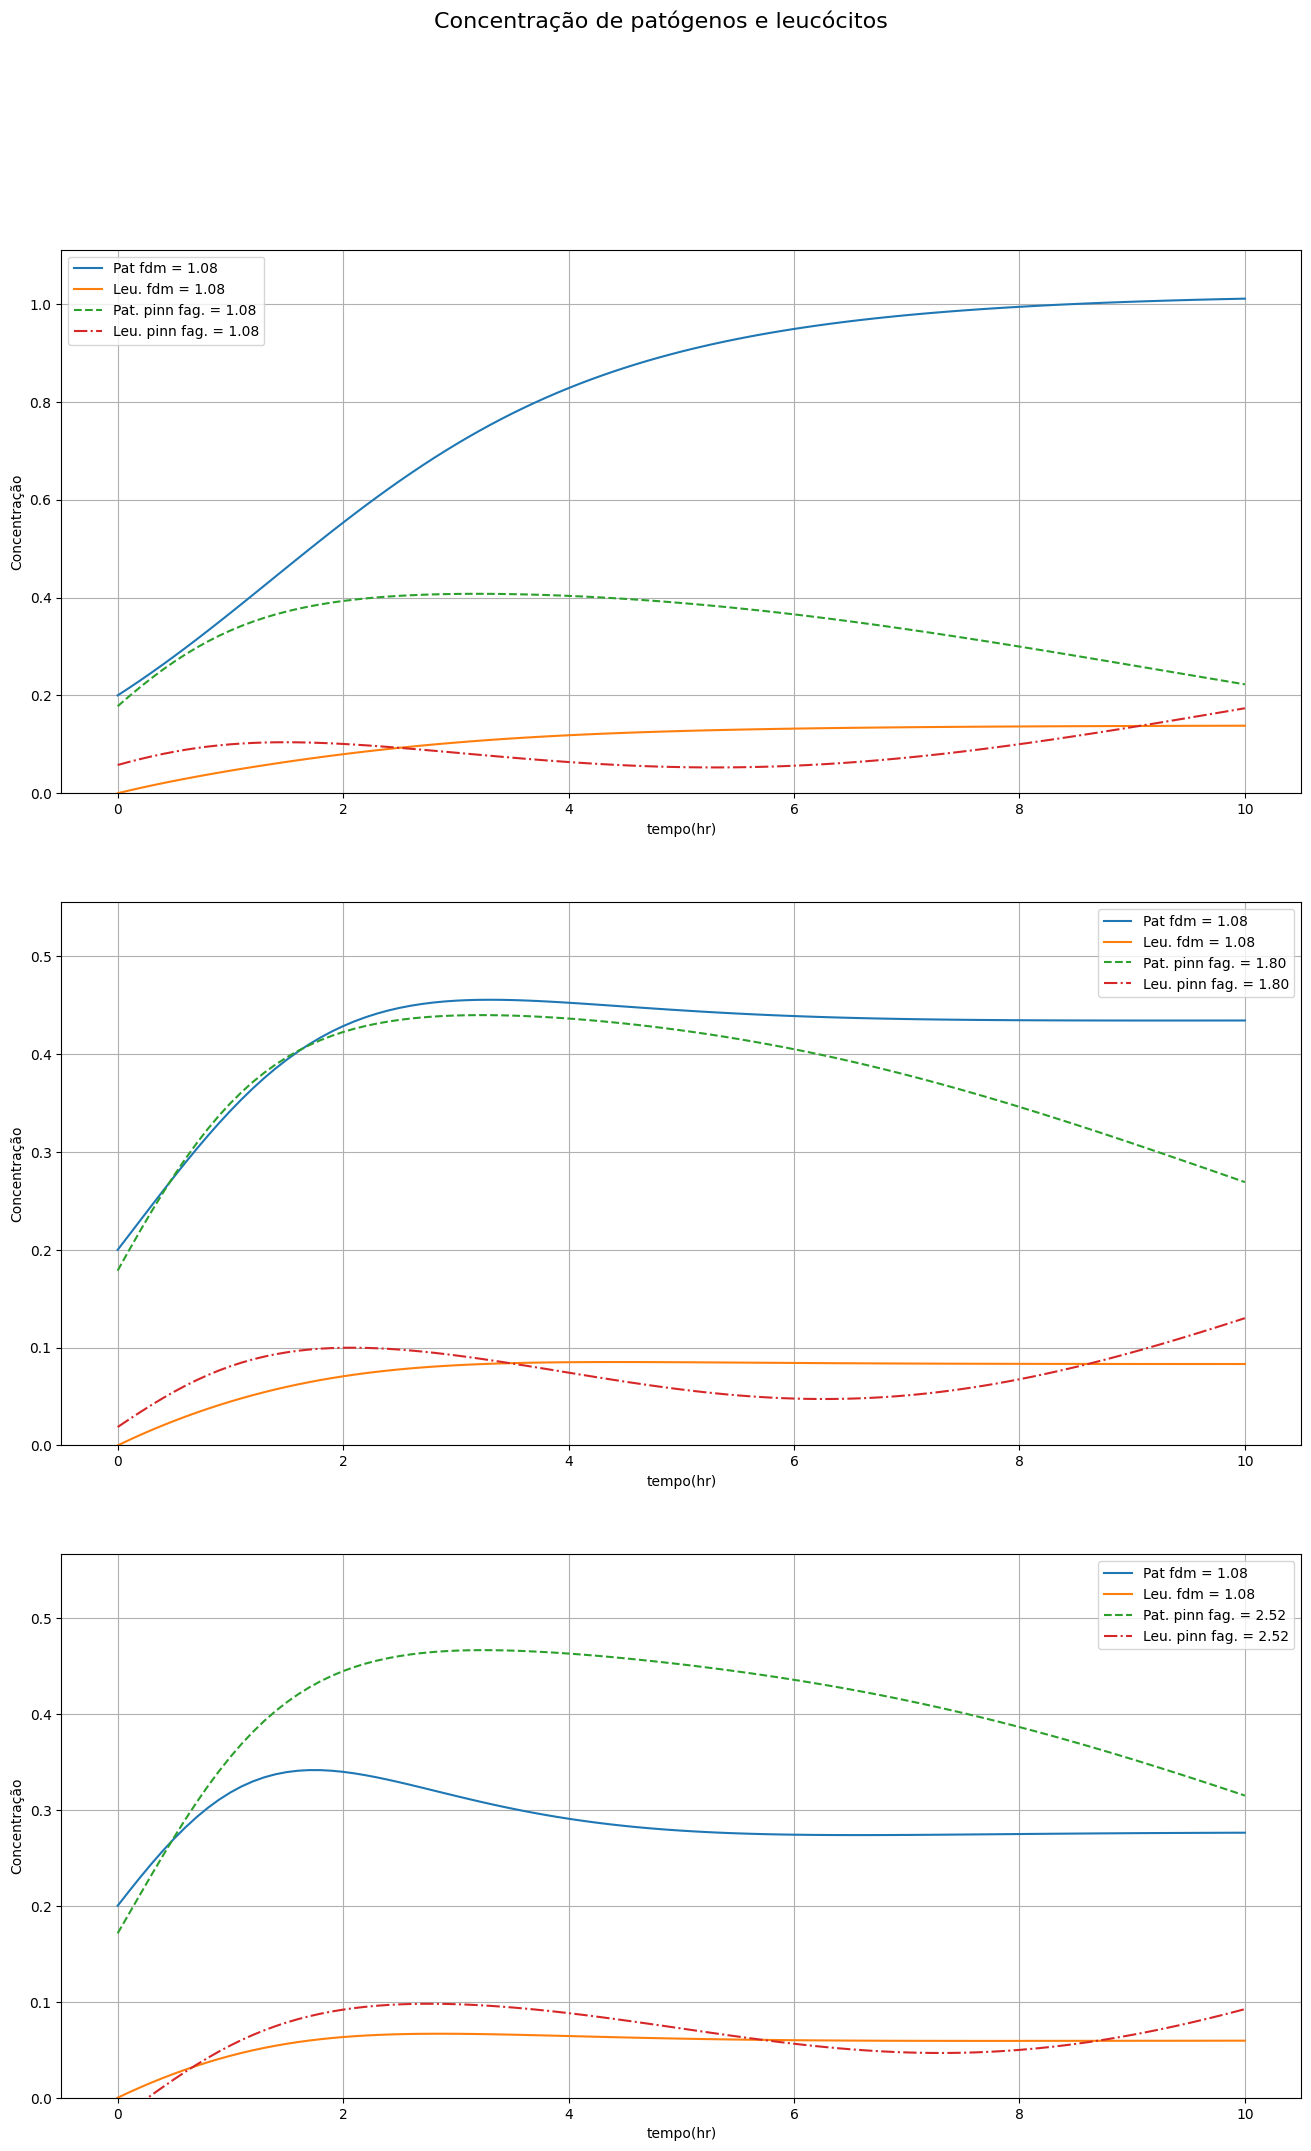

In [25]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[16, 24])

fig.suptitle("Concentração de patógenos e leucócitos", fontsize=16)


vmin = 0

cp_real_1 = Cp[0, :]
cl_real_1 = Cl[0, :]
cp_pinn_1 = Cp_pinn_np[0, :]
cl_pinn_1 = Cl_pinn_np[0, :]
fag_1 = lmb_list[0]

cp_real_2 = Cp[50, :]
cl_real_2 = Cl[50, :]
cp_pinn_2 = Cp_pinn_np[50, :]
cl_pinn_2 = Cl_pinn_np[50, :]
fag_2 = lmb_list[50]

cp_real_3 = Cp[100, :]
cl_real_3 = Cl[100, :]
cp_pinn_3 = Cp_pinn_np[100, :]
cl_pinn_3 = Cl_pinn_np[100, :]
fag_3 = lmb_list[100]

# Plotango 3D
ax = fig.add_subplot(3, 1, 1)

ax.plot(t_np, cp_real_1, label="Pat fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cl_real_1, label="Leu. fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cp_pinn_1, "--", label="Pat. pinn fag. = {:.2f}".format(fag_1))
ax.plot(t_np, cl_pinn_1, "-.", label="Leu. pinn fag. = {:.2f}".format(fag_1))
ax.set_xlabel("tempo(hr)")
ax.set_ylabel("Concentração")

vmax = np.max(
    [
        np.max(cp_real_1),
        np.max(cl_real_1),
        np.max(cp_pinn_1),
        np.max(cl_pinn_1),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

ax = fig.add_subplot(3, 1, 2)

ax.plot(t_np, cp_real_2, label="Pat fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cl_real_2, label="Leu. fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cp_pinn_2, "--", label="Pat. pinn fag. = {:.2f}".format(fag_2))
ax.plot(t_np, cl_pinn_2, "-.", label="Leu. pinn fag. = {:.2f}".format(fag_2))
ax.set_xlabel("tempo(hr)")
ax.set_ylabel("Concentração")
vmax = np.max(
    [
        np.max(cp_real_2),
        np.max(cl_real_2),
        np.max(cp_pinn_2),
        np.max(cl_pinn_2),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

ax = fig.add_subplot(3, 1, 3)

ax.plot(t_np, cp_real_3, label="Pat fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cl_real_3, label="Leu. fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cp_pinn_3, "--", label="Pat. pinn fag. = {:.2f}".format(fag_3))
ax.plot(t_np, cl_pinn_3, "-.", label="Leu. pinn fag. = {:.2f}".format(fag_3))
ax.set_xlabel("tempo(hr)")
ax.set_ylabel("Concentração")
vmax = np.max(
    [
        np.max(cp_real_3),
        np.max(cl_real_3),
        np.max(cp_pinn_3),
        np.max(cl_pinn_3),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

plt.show()

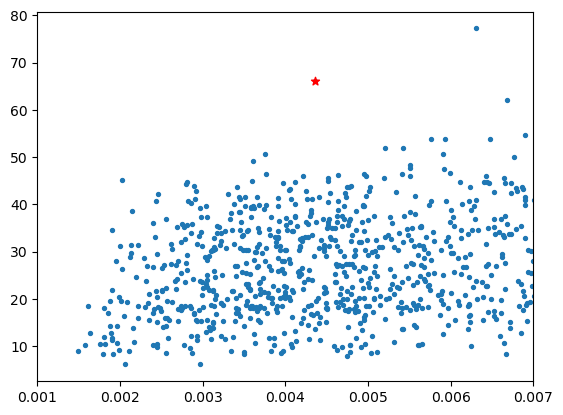

Arquitetura escolhida: epochs_500__batch_10000__arch_Sigmoid--8__


In [ ]:
choice = np.intersect1d(
    np.argwhere(np.array(speed_list) > 60), np.argwhere(np.array(error_list) < 0.005)
)[0]

plt.scatter(error_list, speed_list, s=8)
plt.scatter(error_list[choice], speed_list[choice], c="r", marker="*")
# plt.hlines(25,0.01,0.15)
# plt.vlines(0.0108,min(speed_list),max(speed_list))
plt.xlim(0.001, 0.007)
plt.ylim()
plt.show()

arch_str = results_dict[choice]["arch_name"]

print("Arquitetura escolhida: " + arch_str)

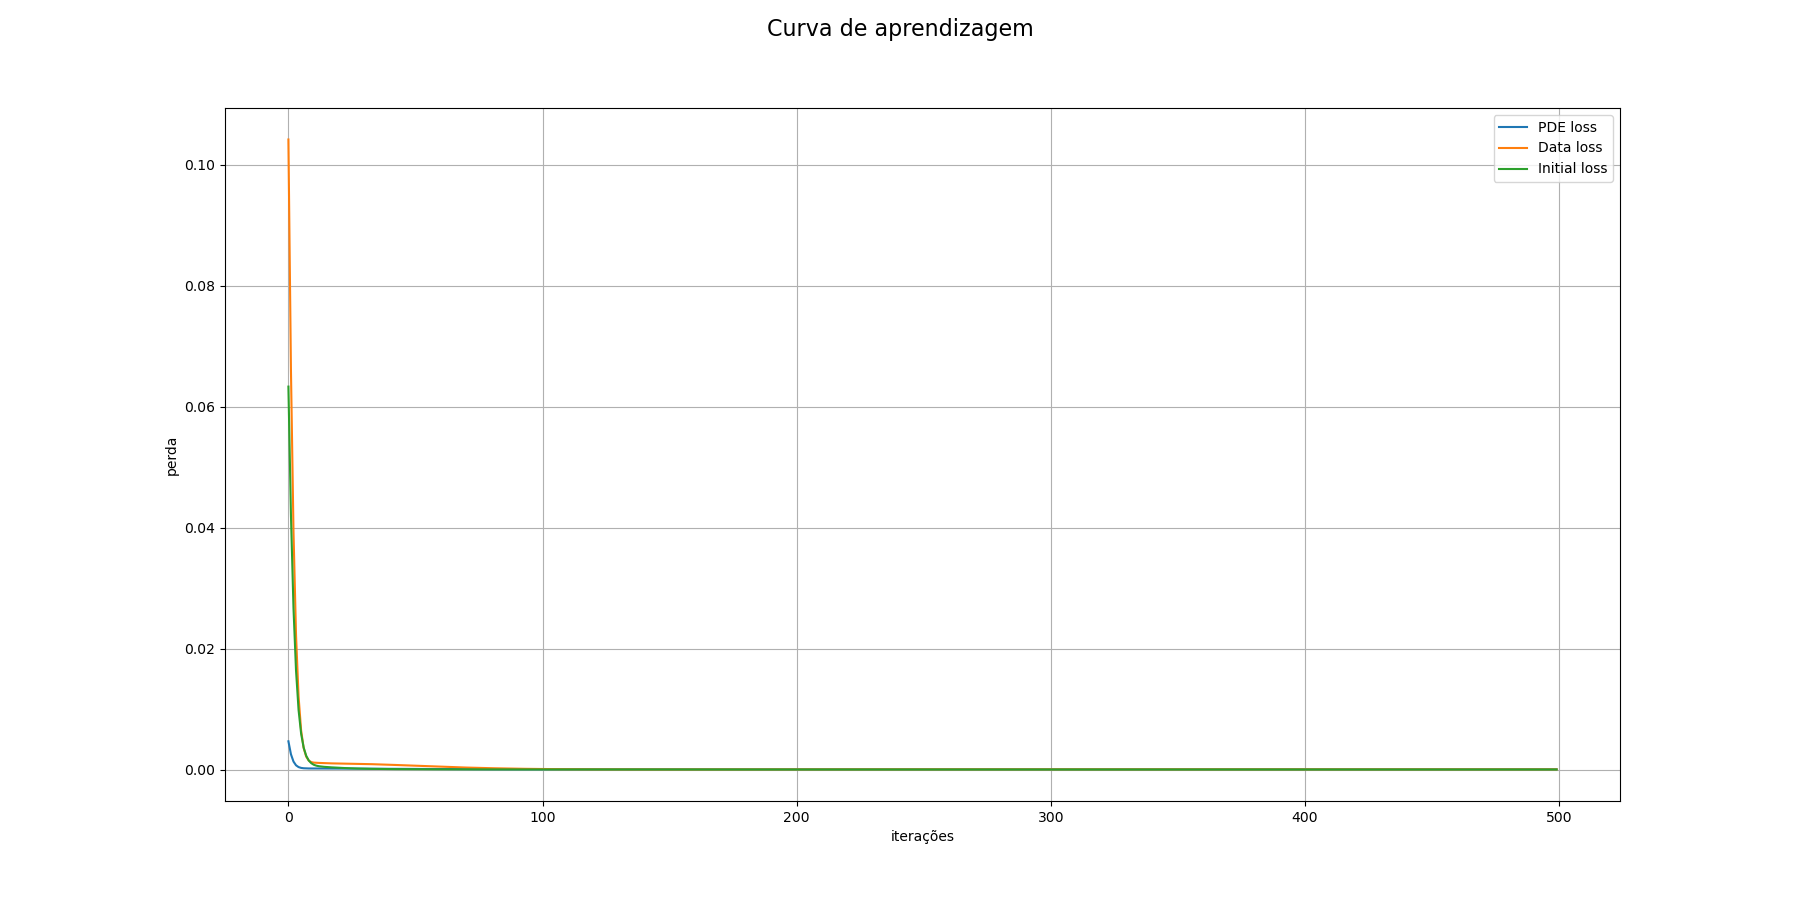

In [ ]:
from IPython.display import Image

Image("learning_curves/" + arch_str + ".png")

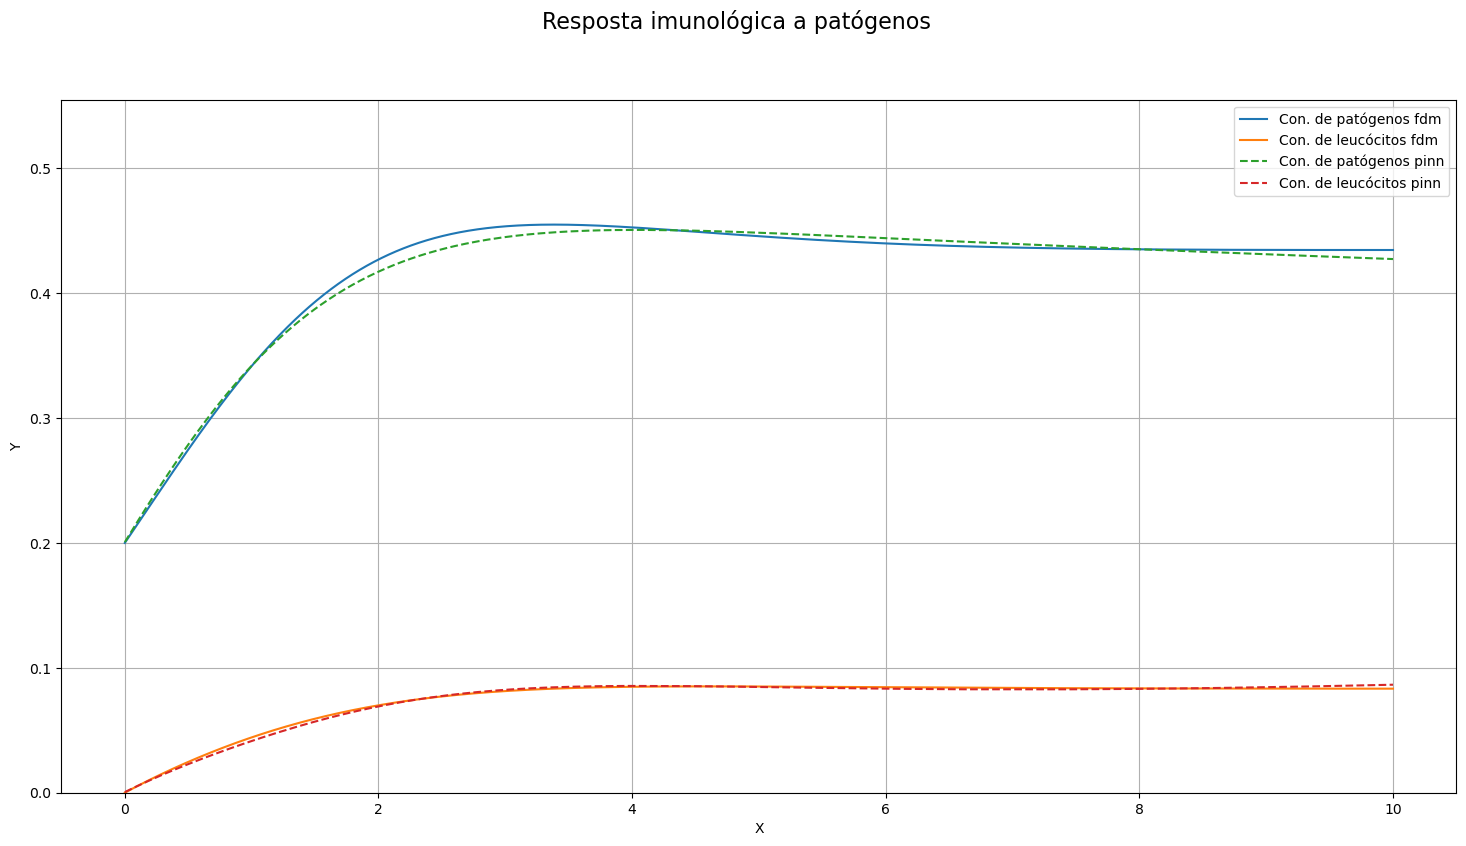

Speed Up: 71.72902047527438 +/-5.64650880588659


In [ ]:
results_dict[choice]

Cl_pinn = results_dict[choice]["Cl_pinn"]
Cp_pinn = results_dict[choice]["Cp_pinn"]

struct_name = "k--0.0001__phi--0.2__ksi--0.0__cb--0.15__Cn_max--0.55__lambd_nb--1.8__mi_n--0.2__lambd_bn--0.1__y_n--0.1__t_lower--0.0__t_upper--10.0"


with open("edo_fdm_sim/Cp__" + struct_name + ".pkl", "rb") as f:
    Cp = pk.load(f)

with open("edo_fdm_sim/Cl__" + struct_name + ".pkl", "rb") as f:
    Cl = pk.load(f)

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)


vmin = 0
vmax = np.max([np.max(Cl), np.max(Cp)])

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.plot(np.linspace(0, 10, num=len(Cp)), Cp, label="Con. de patógenos fdm")
ax.plot(np.linspace(0, 10, num=len(Cp)), Cl, label="Con. de leucócitos fdm")
ax.plot(
    np.linspace(0, 10, num=len(Cp)),
    Cp_pinn,
    label="Con. de patógenos pinn",
    linestyle="--",
)
ax.plot(
    np.linspace(0, 10, num=len(Cp)),
    Cl_pinn,
    label="Con. de leucócitos pinn",
    linestyle="--",
)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

plt.show()

print(
    "Speed Up: {} +/-{}".format(
        results_dict[choice]["mean_speed_up"], results_dict[choice]["std_speed_up"]
    )
)

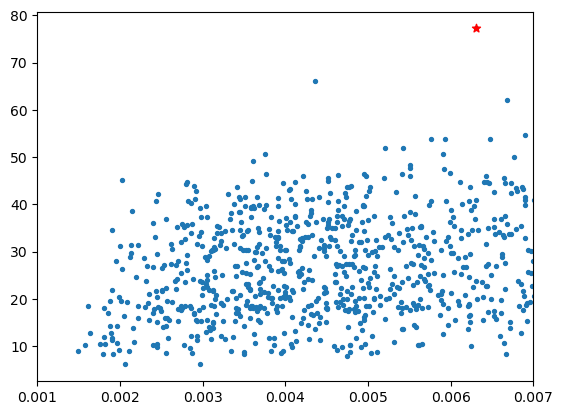

Arquitetura escolhida: epochs_500__batch_10000__arch_Sigmoid--4__


In [ ]:
choice = np.intersect1d(
    np.argwhere(np.array(speed_list) > 70), np.argwhere(np.array(error_list) < 0.007)
)[0]

plt.scatter(error_list, speed_list, s=8)
plt.scatter(error_list[choice], speed_list[choice], c="r", marker="*")
# plt.hlines(25,0.01,0.15)
# plt.vlines(0.0108,min(speed_list),max(speed_list))
plt.xlim(0.001, 0.007)
plt.ylim()
plt.show()

arch_str = results_dict[choice]["arch_name"]

print("Arquitetura escolhida: " + arch_str)

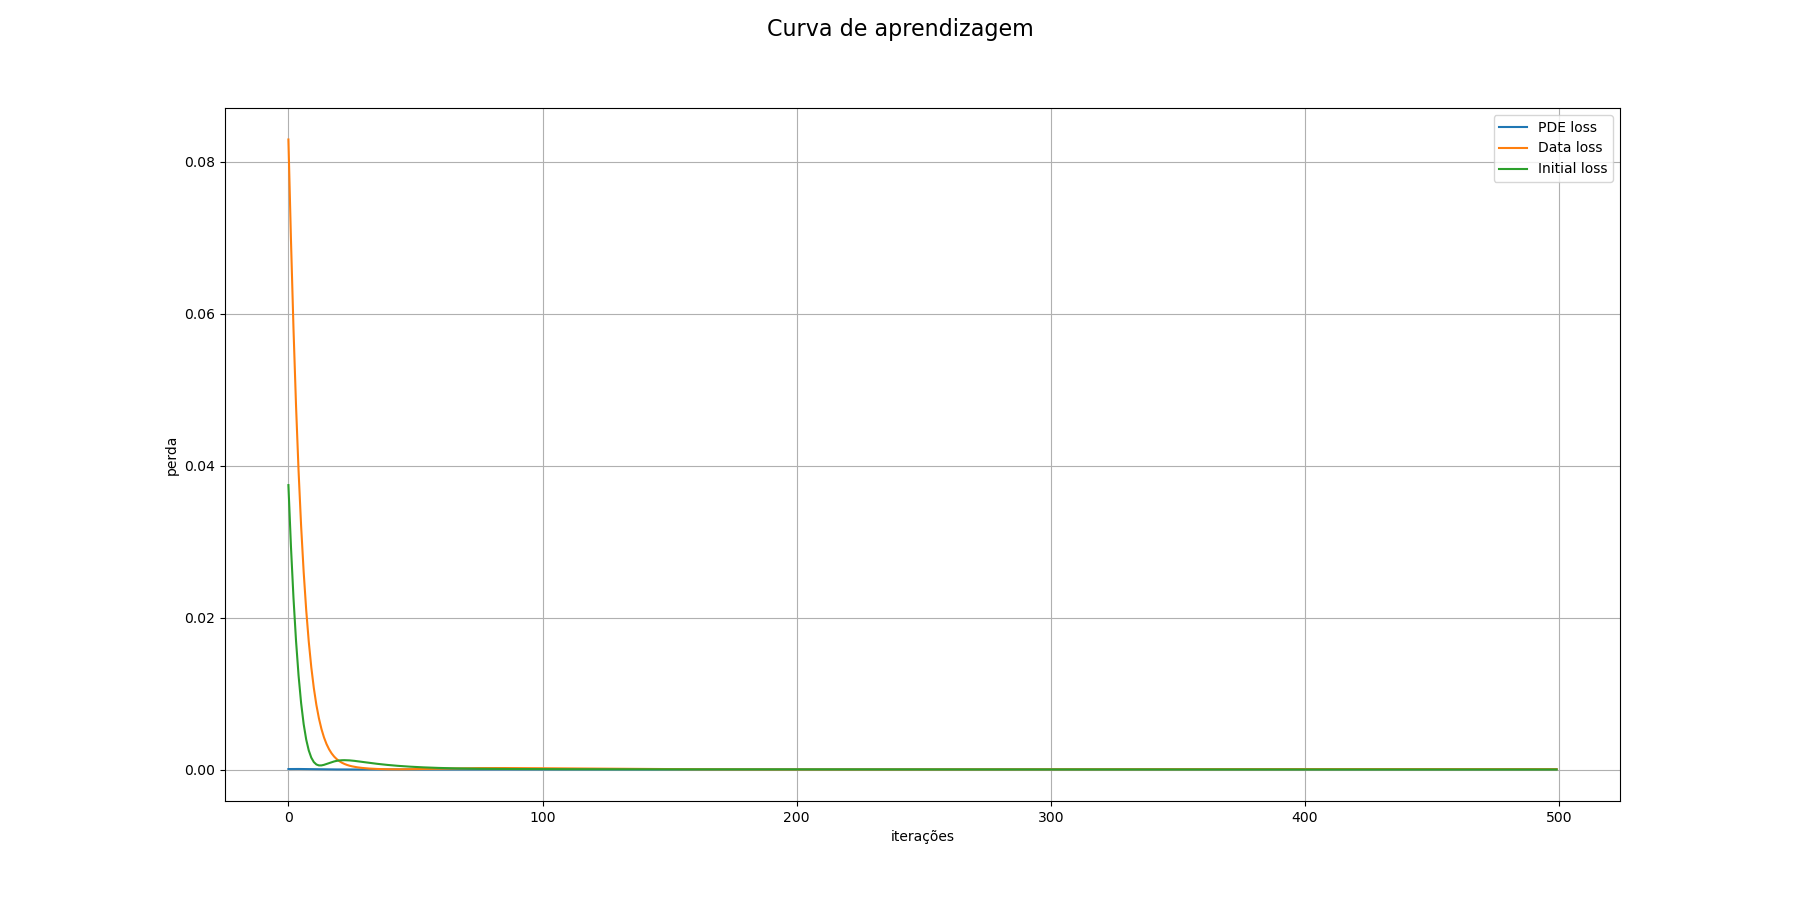

In [ ]:
from IPython.display import Image

Image("learning_curves/" + arch_str + ".png")

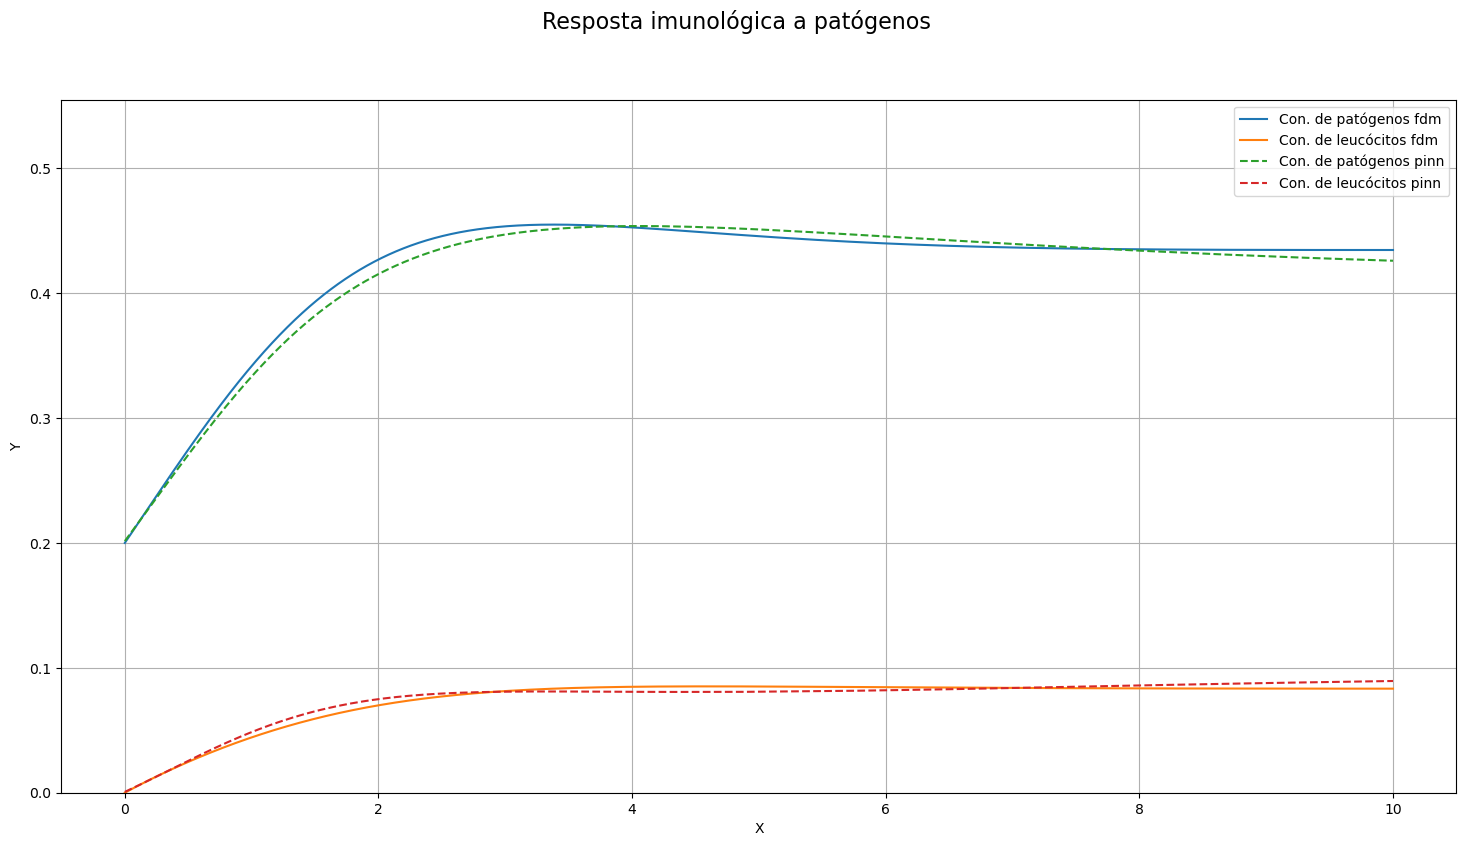

Speed Up: 87.50210925984241 +/-10.297432714839077


In [ ]:
results_dict[choice]

Cl_pinn = results_dict[choice]["Cl_pinn"]
Cp_pinn = results_dict[choice]["Cp_pinn"]

struct_name = "k--0.0001__phi--0.2__ksi--0.0__cb--0.15__Cn_max--0.55__lambd_nb--1.8__mi_n--0.2__lambd_bn--0.1__y_n--0.1__t_lower--0.0__t_upper--10.0"


with open("edo_fdm_sim/Cp__" + struct_name + ".pkl", "rb") as f:
    Cp = pk.load(f)

with open("edo_fdm_sim/Cl__" + struct_name + ".pkl", "rb") as f:
    Cl = pk.load(f)

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)


vmin = 0
vmax = np.max([np.max(Cl), np.max(Cp)])

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.plot(np.linspace(0, 10, num=len(Cp)), Cp, label="Con. de patógenos fdm")
ax.plot(np.linspace(0, 10, num=len(Cp)), Cl, label="Con. de leucócitos fdm")
ax.plot(
    np.linspace(0, 10, num=len(Cp)),
    Cp_pinn,
    label="Con. de patógenos pinn",
    linestyle="--",
)
ax.plot(
    np.linspace(0, 10, num=len(Cp)),
    Cl_pinn,
    label="Con. de leucócitos pinn",
    linestyle="--",
)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

plt.show()

print(
    "Speed Up: {} +/-{}".format(
        results_dict[choice]["mean_speed_up"], results_dict[choice]["std_speed_up"]
    )
)